### Import libraries

In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:82.5% !important}</style>'))

In [2]:
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold, learning_curve

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Paths to directories and files

In [4]:
TRAIN_DATASET_PATH = 'data/train.csv'
TEST_DATASET_PATH = 'data/test.csv'
RES_PATH = 'data/result_submission.csv'

### Loading data

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

### Functions

In [6]:
def evaluate_preds(true_values, pred_values, save=False): 
    print('R2:\t' + str(round(r2_score(true_values, pred_values), 3)) + '\n') 
    plt.figure(figsize=(8, 10))
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig('evaluate_preds.png')
    plt.show()

In [7]:
def show_learning_curve_plot(estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='r2',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15, 8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

    plt.title(f'Learning curves ({type(estimator).__name__})')
    plt.xlabel('Training examples')
    plt.ylabel('Score')     
    plt.legend(loc='best')
    plt.grid()
    plt.show()

### Feature engineering / Работа с признаками

In [8]:
def feature_engineering(df):
    # Корректировка даты строительства дома
    df.loc[df['HouseYear'] > 2020, 'HouseYear'] = 1985
    
    # Уменьшение количества выбросов
    df.loc[(df['LifeSquare'] < 8.42) | (df['LifeSquare'].isnull()), 'LifeSquare'] = df['Square'] * 0.83
    df.loc[df['LifeSquare'] > 242, 'LifeSquare'] = 442
    
    # Уменьшение количества выбросов
    df.loc[(df['Square'] > 312), 'Square'] = 42
    
    # Заполняем пустые значения здравохранения
    df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = 1142
    
    # Приравниваем к среднему большое кол-во комнат
    df.loc[(df['Rooms'] > 10) & (df['Rooms'] < 1), 'Rooms'] = 2
    
    # Если площадь большая, то комнат 6
    df.loc[(df['Rooms'] < 1) & (df['LifeSquare'] >= 80), 'Rooms'] = 6
    
    # Преобразование типа признака по значению и удаление первоисточника
    df['Ecology_b2'] = (df['Ecology_2'] == 'A').astype('bool')
    df.drop('Ecology_2', axis=1, inplace=True)
    df['Ecology_b3'] = (df['Ecology_3'] == 'A').astype('bool')
    df.drop('Ecology_3', axis=1, inplace=True)
    df['Shops_b2'] = (df['Shops_2'] == 'A').astype('bool')
    df.drop('Shops_2', axis=1, inplace=True)
    
    # Создание признака, который указывает на первый этаж
    df['FirstFloor'] = (df['Floor'] == df['HouseFloor']) | (df['Floor'] <= 1)
    df['FirstFloor'] = df['FirstFloor'].astype('float')
    
    # Признак, который делит по соотношению жилой и общей площади
    df['Life_sq'] = ((df['LifeSquare'] / df['Square']) < 0.85).astype('bool')
    
    # Уменьшаем размерность типов данных
    df[['Rooms', 'Floor', 'HouseFloor', 'HouseYear']] = df[['Rooms', 'Floor', 'HouseFloor', 'HouseYear']].astype('int32')
    
    # Создание признака - старого дома
    df['OldHouse'] = (df['HouseYear'] < 1935).astype('bool')
    
    # Уменьшение количества выбросов
    df.loc[df['LifeSquare'] > df['Square'], 'LifeSquare'] = df['Square'] * 0.87

In [9]:
feature_engineering(train_df)
feature_engineering(test_df)

### Correlation

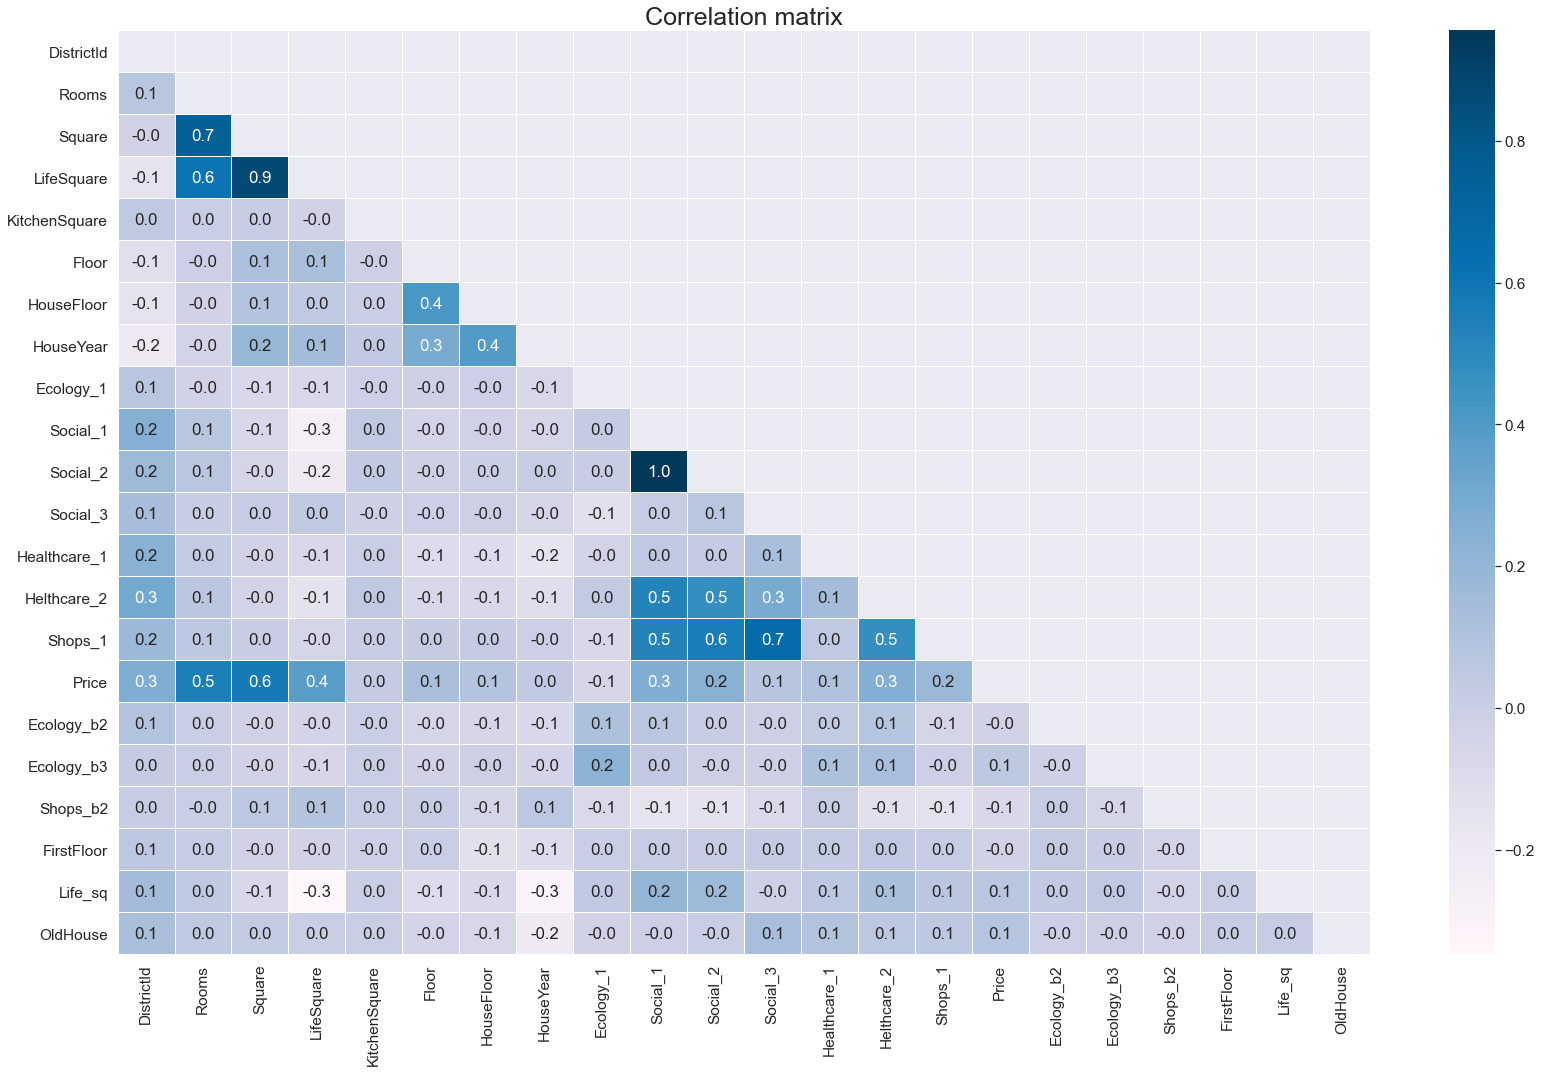

In [10]:
# Correlation Matrix
num_features = pd.DataFrame(train_df)
num_features.drop('Id', axis=1, inplace=True)

corr = num_features.corr()
plt.figure(figsize = (25, 17))
mask = np.zeros_like(corr, dtype=np.bool)  # отрезаем лишнюю половину матрицы
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)
sns.heatmap(num_features.corr(), mask=mask, annot=True, fmt='.1f', linewidths=.5, cmap='PuBu')
plt.title('Correlation matrix', fontsize=25)
plt.show()

In [11]:
correlation = train_df.corr()
corr_with_target = correlation['Price'].sort_values(ascending = False)
corr_with_target

Price            1.000000
Square           0.577984
Rooms            0.549871
LifeSquare       0.379123
DistrictId       0.265100
Social_1         0.263286
Helthcare_2      0.253090
Social_2         0.239226
Shops_1          0.180876
Floor            0.128715
Healthcare_1     0.105507
HouseFloor       0.088280
OldHouse         0.084807
Social_3         0.074878
Life_sq          0.071149
Ecology_b3       0.052585
HouseYear        0.036607
KitchenSquare    0.028864
Id               0.009880
Ecology_b2      -0.022379
FirstFloor      -0.025505
Ecology_1       -0.058381
Shops_b2        -0.070388
Name: Price, dtype: float64

### Building the model

In [12]:
X = train_df.drop(['Price', 'Id'], axis=1)
y = train_df['Price'] 

#### GradientBoostingRegressor

In [13]:
model_gbr = GradientBoostingRegressor(n_estimators=4573, max_depth=5, min_samples_split=3, loss='ls', 
                                      learning_rate=0.1, random_state=62, min_samples_leaf=1) 

#### RandomForestRegressor

In [14]:
model_rfr = RandomForestRegressor(n_estimators=555, max_depth=18, random_state=62, max_features=7, n_jobs=-1)

#### VotingRegressor

In [15]:
model_vr = VotingRegressor([('model_gbr', model_gbr), ('model_rfr', model_rfr)])

#### Cross-validation

In [16]:
%%time
cv_score = cross_val_score(model_vr, X, y, scoring='r2', cv=KFold(n_splits=10, shuffle=True, random_state=62))

Wall time: 16min 47s


In [17]:
print(f'Mean R2 score: {round(np.mean(cv_score), 4)}, std: {round(np.std(cv_score), 4)}')

Mean R2 score: 0.7555, std: 0.0205


In [18]:
%%time
model_vr.fit(X, y)

Wall time: 1min 47s


VotingRegressor(estimators=[('model_gbr',
                             GradientBoostingRegressor(max_depth=5,
                                                       min_samples_split=3,
                                                       n_estimators=4573,
                                                       random_state=62)),
                            ('model_rfr',
                             RandomForestRegressor(max_depth=18, max_features=7,
                                                   n_estimators=555, n_jobs=-1,
                                                   random_state=62))])

In [19]:
model_vr.score(X, y)

0.9871887795634627

R2:	0.987



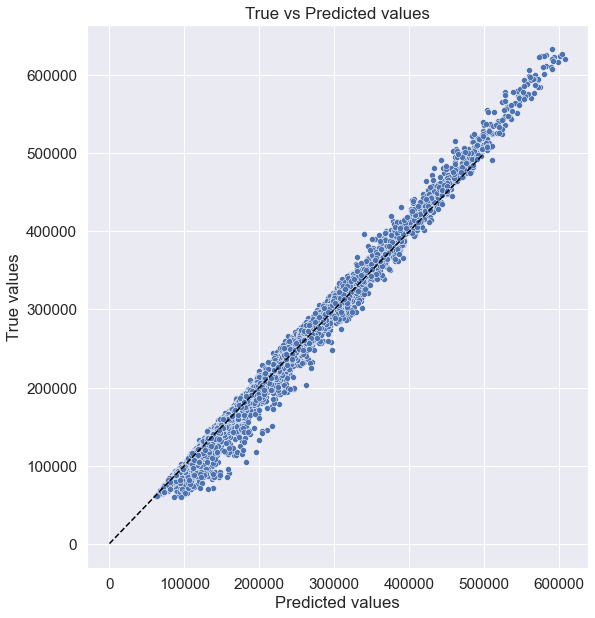

In [20]:
train_predictions = model_vr.predict(X)
evaluate_preds(y, train_predictions)

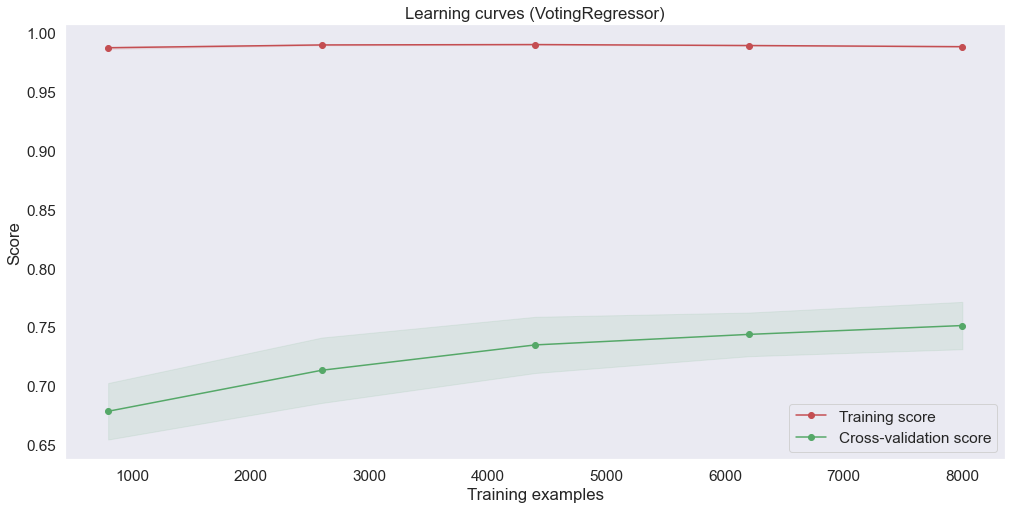

In [21]:
show_learning_curve_plot(model_vr, X, y)

### Result

In [22]:
test = test_df.drop(['Id'], axis=1)

In [23]:
test_df['Price'] = model_vr.predict(test)
test_df.loc[:, ['Id', 'Price']].to_csv(RES_PATH, index=False, encoding='utf-8')